In [7]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

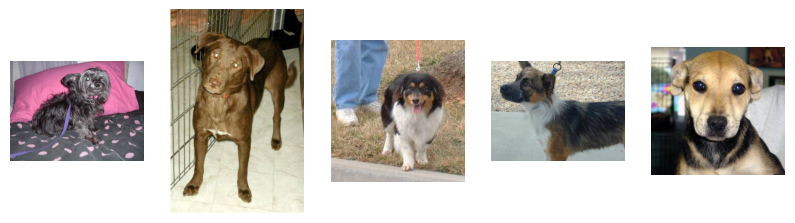

In [8]:
train_folder = 'dogs-vs-cats/train/'
fig = plt.figure(figsize=(10,10))
for i in range(5):
    fig.add_subplot(1,5,i+1)
    filename = train_folder + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.axis("off") 

In [9]:
from os import makedirs
from os import listdir
from shutil import copyfile
from random import random,seed

In [10]:
dataset_home = './'
subdirs = ['train/', 'validation/']

In [11]:
for subdir in subdirs:
    
    labeldirs = ['dogs/', 'cats/']
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        makedirs(newdir, exist_ok=True)

In [12]:
seed(1)
val_ratio = 0.1

src_directory = 'dogs-vs-cats/train'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'validation/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/' + file
        copyfile(src,dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/' + file
        copyfile(src,dst)

In [13]:
from keras.preprocessing.image import ImageDataGenerator

2023-06-14 08:45:02.587328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 08:45:03.778592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
datagen = ImageDataGenerator(rescale=1.0/255.0, 
                             rotation_range=45,
                             width_shift_range=.15,
                             height_shift_range=.15,
                             horizontal_flip=True,
                             zoom_range=0.5)

In [15]:
train_iterator = datagen.flow_from_directory('./train',
                                             class_mode='binary',
                                             batch_size=64,
                                             target_size=(224,224),
                                             shuffle=True)

Found 22412 images belonging to 2 classes.


In [16]:
validation_iterator = datagen.flow_from_directory('./validation/',
                                                  class_mode='binary',
                                                  batch_size=64,
                                                  target_size=(224,224))

Found 2588 images belonging to 2 classes.


In [17]:
def plot_5_images(images):
    fig,axes = plt.subplots(1,5, figsize=(20,20))
    axes = axes.flatten()
    for img,ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

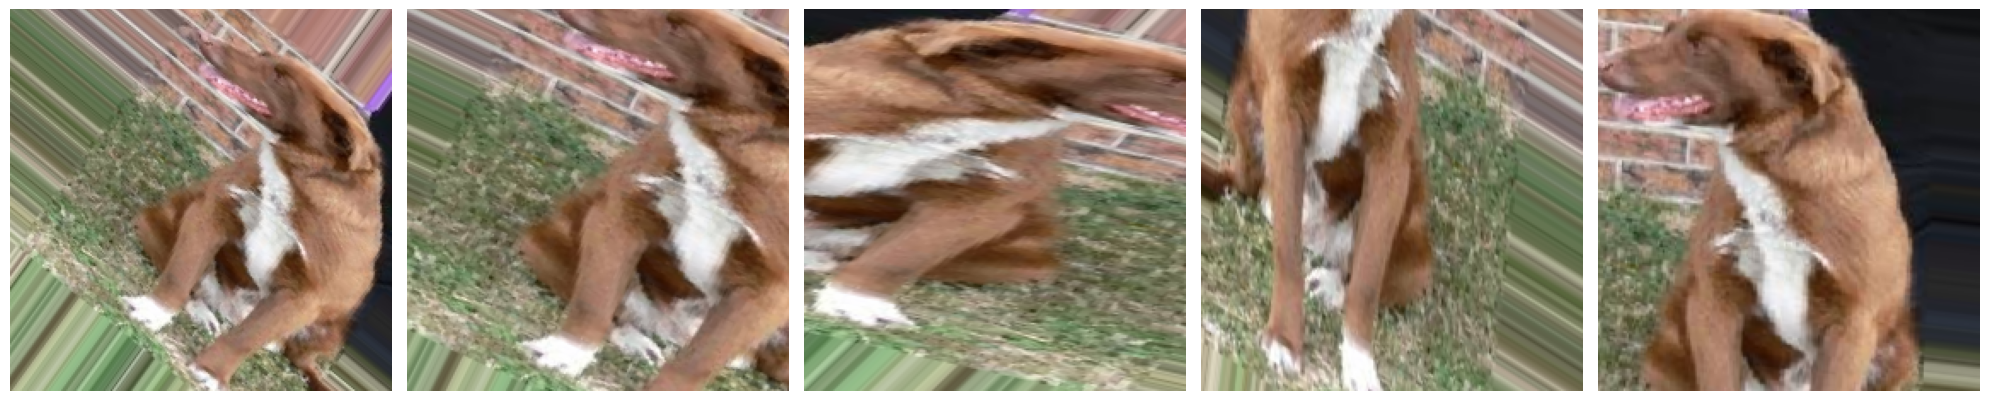

In [18]:
augmented = [validation_iterator[0][0][0] for i in range(5)]
plot_5_images(augmented)

In [19]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [20]:
vgg_model = VGG16(include_top=False, input_shape=(224,224,3))
vgg_model.trainable = False

2023-06-14 08:45:09.317425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:45:09.601295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:45:09.601557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:45:09.603219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:45:09.603530: I tensorflow/compile

In [21]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss',
                   patience=2,
                   mode='min',
                   verbose=1)

In [24]:
import tensorflow as tf

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


2023-06-14 08:45:14.486699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:45:14.487045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:45:14.487289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:45:14.487726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 08:45:14.487740: I tensorflow/core/co

In [25]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
model.fit(train_iterator, 
          steps_per_epoch=len(train_iterator),
          validation_data=validation_iterator,
          validation_steps=len(validation_iterator),
          epochs=10,
          callbacks=[es])

Epoch 1/10


2023-06-14 08:45:15.012996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-14 08:45:17.300806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-14 08:45:18.792517: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-14 08:45:23.442612: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1b3275e950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-14 08:45:23.442651: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-06-14 08:45:23.493702: I tensorflow/compiler/mlir/tensorflo

351/351 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8146

2023-06-14 08:47:53.392673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 [==============================] - 178s 483ms/step - loss: 0.4081 - accuracy: 0.8146 - val_loss: 0.3000 - val_accuracy: 0.8709
Epoch 2/10
351/351 [==============================] - 165s 469ms/step - loss: 0.3114 - accuracy: 0.8642 - val_loss: 0.2978 - val_accuracy: 0.8663
Epoch 3/10
351/351 [==============================] - 166s 473ms/step - loss: 0.3094 - accuracy: 0.8606 - val_loss: 0.3086 - val_accuracy: 0.8640
Epoch 4/10
351/351 [==============================] - 182s 517ms/step - loss: 0.2879 - accuracy: 0.8719 - val_loss: 0.2934 - val_accuracy: 0.8736
Epoch 5/10
351/351 [==============================] - 167s 476ms/step - loss: 0.2827 - accuracy: 0.8760 - val_loss: 0.2847 - val_accuracy: 0.8706
Epoch 6/10
351/351 [==============================] - 165s 471ms/step - loss: 0.2842 - accuracy: 0.8754 - val_loss: 0.2775 - val_accuracy: 0.8752
Epoch 7/10
351/351 [==============================] - 167s 476ms/step - loss: 0.2816 - accuracy: 0.8752 - val_loss: 0.2799 - val_accura

In [27]:
_,acc = model.evaluate(validation_iterator,
                       steps=len(validation_iterator))

2023-06-14 09:18:33.275191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 188s 5s/step - loss: 0.2753 - accuracy: 0.8752


In [28]:
print('Accuracy = %.3f' % (acc * 100.0))

Accuracy = 87.519


In [39]:
src_directory = './dogs-vs-cats/test'
makedirs('./test', exist_ok=True)
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst = 'test/'+file
    copyfile(src,dst)

In [41]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_iterator = datagen.flow_from_directory('./test',
                                            classes=['dog'],
                                            batch_size=64,
                                            target_size=(244,244))

Found 0 images belonging to 1 classes.
